In [57]:
import sqlite3
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [4]:
conn = sqlite3.connect('redditPosts_KCL.sqlite')
query = 'SELECT * FROM Posts P JOIN PostBodyAndScore B ON P.id = B.id'
df = pd.read_sql(sql=query, con=conn)
df.head(2)

,subreddit,title,author,created,ext_link,score,upvote_ratio
0,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,1609505868,None,1,1.0
1,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,1609507913,https://www.fintechinshorts.com/mogo-establish...,1,1.0


## Dropping unnecessary columns

In [3]:
df.drop(['id','body','url'], axis=1, inplace=True)
df.head()

,subreddit,title,author,created,ext_link,score,upvote_ratio
0,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,1609505868,None,1,1.0
1,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,1609507913,https://www.fintechinshorts.com/mogo-establish...,1,1.0
2,finance,"NYSE to delist three Chinese telecom firms, ci...",QQQult,1609512819,https://www.theguardian.com/business/2021/jan/...,1,1.0
3,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,1609518689,https://www.fintechinshorts.com/standard-capit...,1,1.0
4,finance,5 things every trader needs to know,Aversionsfall,1609519854,https://yvestalksbitcoin.com/2021/01/01/5-thin...,0,0.4


## Selecting subreddit with complete dataset

In [5]:
df = df[(df.subreddit == 'Superstonks') |
        (df.subreddit == 'finance') |
        (df.subreddit == 'options') |
        (df.subreddit == 'pennystocks')]

## Transforming time info

In [7]:
df['posting_time'] = df['created'].apply(dt.datetime.fromtimestamp)
df.drop('created', axis=1, inplace=True)
df.head()

,subreddit,title,author,ext_link,score,upvote_ratio,posting_time
0,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,None,1,1.0,2021-01-01 07:57:48
1,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.fintechinshorts.com/mogo-establish...,1,1.0,2021-01-01 08:31:53
2,finance,"NYSE to delist three Chinese telecom firms, ci...",QQQult,https://www.theguardian.com/business/2021/jan/...,1,1.0,2021-01-01 09:53:39
3,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.fintechinshorts.com/standard-capit...,1,1.0,2021-01-01 11:31:29
4,finance,5 things every trader needs to know,Aversionsfall,https://yvestalksbitcoin.com/2021/01/01/5-thin...,0,0.4,2021-01-01 11:50:54


In [16]:
df['posting_year'] = df['posting_time'].dt.year
df['posting_month'] = df['posting_time'].dt.month
df['posting_date'] = df['posting_time'].dt.day
df['posting_date'] = df['posting_time'].dt.day

def to_hour(inp):
    return inp.hour + (inp.minute/60.) + (inp.second/3600.)

df['posting_hour'] = df['posting_time'].apply(to_hour)

In [21]:
df.drop('posting_time', axis=1, inplace=True)

## Extracting the external link

In [18]:
image_file_formats = ['ai','bmp','gif','ico','jpg','jpeg','png','ps','psd','svg','tif','tiff']
video_file_formats = ['.3g2','3gp','avi','flv','h264','m4v','mkv','mov','mp4','mpg','mpeg','rm','swf','vob','wmv']

In [19]:
def get_ext_media(inp):
    if inp == None:
        last_term = 'None'
    else:
        last_term = inp.split('.')[-1]
        
    if (last_term in image_file_formats) or (last_term in video_file_formats):
        out = 1
    else:
        out = 0
    return out

df['ext_link_media'] = df['ext_link'].apply(get_ext_media)

In [25]:
def get_ext_web(inp):
    if inp == None:
        last_term = 'None'
    else:
        last_term = inp.split('.')[-1]

    if (last_term not in image_file_formats+video_file_formats) and (last_term != 'None'):
        out = 1
    else:
        out = 0
    return out

df['ext_link_web'] = df['ext_link'].apply(get_ext_web)

In [29]:
df.drop('ext_link', axis=1, inplace=True)

In [30]:
df.head(2)

,subreddit,title,author,score,upvote_ratio,posting_year,posting_month,posting_date,posting_hour,ext_link_media,ext_link_web
0,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,1,1.0,2021,1,1,7.963333,0,0
1,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,1,1.0,2021,1,1,8.531389,0,1


## Making one-hot-encoding from subreddit forum

In [38]:
df = pd.concat([df, pd.get_dummies(df.subreddit, drop_first=True)], axis=1)
df.drop('subreddit', axis=1, inplace=True)

In [39]:
df.head(2)

,title,author,score,upvote_ratio,posting_year,posting_month,posting_date,posting_hour,ext_link_media,ext_link_web,finance,options,pennystocks
0,Tech's top seven companies added $3.4 trillion...,Obrocheetah,1,1.0,2021,1,1,7.963333,0,0,1,0,0
1,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,1,1.0,2021,1,1,8.531389,0,1,1,0,0


## Calculate the length of title text

In [41]:
tokenizer = TweetTokenizer()
df['tokens'] = df['title'].str.lower().apply(tokenizer.tokenize)
df['title_length'] = df['tokens'].apply(len)
df.drop('title', axis=1, inplace=True)

In [42]:
df.head(2)

,author,score,upvote_ratio,posting_year,posting_month,posting_date,posting_hour,ext_link_media,ext_link_web,finance,options,pennystocks,tokens,title_length
0,Obrocheetah,1,1.0,2021,1,1,7.963333,0,0,1,0,0,"[tech's, top, seven, companies, added, $, 3.4,...",12
1,fintechinshorts,1,1.0,2021,1,1,8.531389,0,1,1,0,0,"[mogo, :, establishes, atm, equity, program, m...",18


## Extract author information

In [43]:
author_votes = df.groupby('author').upvote_ratio.mean()
author_votes.head()

author
--------sam           1.000000
----The_Truth-----    0.931667
---Tsing__Tao---      1.000000
--Superb              0.765385
--_--_--__--_--_--    0.920000
Name: upvote_ratio, dtype: float64

In [75]:
author_scores = df.groupby('author').score.mean()
author_scores.head()

author
--------sam            12.000000
----The_Truth-----    118.761905
---Tsing__Tao---        1.000000
--Superb                6.615385
--_--_--__--_--_--     20.000000
Name: score, dtype: float64

In [70]:
author_votes['[deleted]']

0.9535735865343123

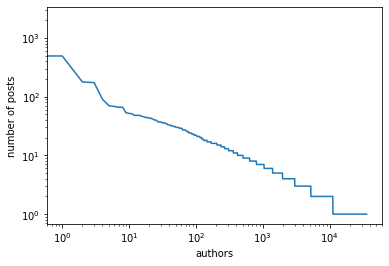

In [63]:
num_post_per_author = df['author'].value_counts().values
plt.plot(range(len(num_post_per_author)), num_post_per_author)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('number of posts')
plt.xlabel('authors')
plt.show()

In [66]:
author_posts = df['author'].value_counts()
author_posts.head()

[deleted]          2317
fintechinshorts     492
kmuinnovation       178
PennyBotWeekly      173
Front-Page_News      90
Name: author, dtype: int64

In [68]:
author_posts['fintechinshorts'] > 1

True

In [69]:
author_votes['fintechinshorts']

1.0

In [71]:
def log_num_posts(author):
    return np.log10(author_posts[author])

df['log_num_posts'] = df['author'].apply(log_num_posts)

In [73]:
def mean_upvotes(author):
    return author_votes[author]

df['mean_upvotes'] = df['author'].apply(mean_upvotes)

In [76]:
def mean_scores(author):
    return author_scores[author]

df['mean_scores'] = df['author'].apply(mean_scores)

In [77]:
df.head(2)

,author,score,upvote_ratio,posting_year,posting_month,posting_date,posting_hour,ext_link_media,ext_link_web,finance,options,pennystocks,tokens,title_length,log_num_posts,mean_upvotes,mean_scores
0,Obrocheetah,1,1.0,2021,1,1,7.963333,0,0,1,0,0,"[tech's, top, seven, companies, added, $, 3.4,...",12,0.000000,1.0,1.0
1,fintechinshorts,1,1.0,2021,1,1,8.531389,0,1,1,0,0,"[mogo, :, establishes, atm, equity, program, m...",18,2.691965,1.0,1.0


# Splitting Data into train and test set

In [81]:
from sklearn.model_selection import train_test_split

X = df.drop(['author', 'score', 'upvote_ratio', 'posting_year', 'tokens'], axis=1)
y = df['upvote_ratio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [85]:
len(y[y < 1])/len(X_train)

0.392744537322188

## Let's make it classification problem

In [86]:
y_train[y_train < 1] = 0
y_test[y_test < 1] = 0

## Checking the variance of the data

In [123]:
X_train.describe()

,posting_month,posting_date,posting_hour,ext_link_media,ext_link_web,finance,options,pennystocks,title_length,log_num_posts,mean_upvotes,mean_scores
count,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000
mean,2.166282,15.024839,13.229619,0.116348,0.883506,0.043481,0.243382,0.710973,10.959653,0.553944,0.919555,25.860538
std,1.088272,9.130844,5.748649,0.320644,0.320820,0.203940,0.429128,0.453315,9.491823,0.723433,0.124088,231.703401
min,1.000000,1.000000,0.000556,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.050000,0.000000
25%,1.000000,8.000000,9.812500,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.876667,1.000000
50%,2.000000,14.000000,13.244167,0.000000,1.000000,0.000000,0.000000,1.000000,8.000000,0.301030,0.988387,1.000000
75%,3.000000,23.000000,17.438264,0.000000,1.000000,0.000000,0.000000,1.000000,14.000000,0.778151,1.000000,6.000000
max,5.000000,31.000000,23.999167,1.000000,1.000000,1.000000,1.000000,1.000000,138.000000,3.364926,1.000000,20239.000000


## Scaling the continuum features

In [124]:
X_train.columns

Index(['posting_month', 'posting_date', 'posting_hour', 'ext_link_media',
       'ext_link_web', 'finance', 'options', 'pennystocks', 'title_length',
       'log_num_posts', 'mean_upvotes', 'mean_scores'],
      dtype='object')

In [127]:
from sklearn.preprocessing import StandardScaler

scaled_cols = ['posting_month','posting_date','posting_hour','title_length','mean_scores']

for col in scaled_cols:

    scaler = StandardScaler()

    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
    X_test[col]  = scaler.transform(X_test[col].values.reshape(-1,1))

<ipython-input-127-880f9fa1de29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
<ipython-input-127-880f9fa1de29>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col]  = scaler.transform(X_test[col].values.reshape(-1,1))
<ipython-input-127-880f9fa1de29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [128]:
X_train.describe()

,posting_month,posting_date,posting_hour,ext_link_media,ext_link_web,finance,options,pennystocks,title_length,log_num_posts,mean_upvotes,mean_scores
count,5.455200e+04,5.455200e+04,5.455200e+04,54552.000000,54552.000000,54552.000000,54552.000000,54552.000000,5.455200e+04,54552.000000,54552.000000,5.455200e+04
mean,1.372841e-16,-2.500810e-17,-6.857691e-17,0.116348,0.883506,0.043481,0.243382,0.710973,9.697153e-17,0.553944,0.919555,4.819270e-18
std,1.000009e+00,1.000009e+00,1.000009e+00,0.320644,0.320820,0.203940,0.429128,0.453315,1.000009e+00,0.723433,0.124088,1.000009e+00
min,-1.071692e+00,-1.535999e+00,-2.301269e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.049297e+00,0.000000,0.050000,-1.116115e-01
25%,-1.071692e+00,-7.693596e-01,-5.944268e-01,0.000000,1.000000,0.000000,0.000000,0.000000,-6.278781e-01,0.000000,0.876667,-1.072956e-01
50%,-1.527957e-01,-1.122402e-01,2.530589e-03,0.000000,1.000000,0.000000,0.000000,1.000000,-3.118137e-01,0.301030,0.988387,-1.072956e-01
75%,7.661010e-01,8.734389e-01,7.321170e-01,0.000000,1.000000,0.000000,0.000000,1.000000,3.203151e-01,0.778151,1.000000,-8.571614e-02
max,2.603894e+00,1.749598e+00,1.873422e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.338431e+01,3.364926,1.000000,8.723793e+01


# Modeling

## Logistic Regression

In [129]:
logreg = LogisticRegression(max_iter=10000, solver='liblinear')
param_grid = {'C': [1,10,100,1000],
              'penalty': ['l1','l2']}
gs = GridSearchCV(logreg, param_grid=param_grid)
gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2']})

In [130]:
gs.best_params_

{'C': 100, 'penalty': 'l2'}

In [131]:
gs.best_score_

0.830693625560226

In [133]:
y_pred = gs.predict(X_test)
accuracy_score(y_test, y_pred)

0.8320868162487168

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve

## Random Forest

In [157]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 20]}

gs = GridSearchCV(rfc, param_grid=param_grid)

gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20]})

In [158]:
gs.best_params_

{'max_depth': 10}

In [159]:
gs.best_score_

0.8767230994276582

In [160]:
y_pred = gs.predict(X_test)
accuracy_score(y_test, y_pred)

0.8751283179351811

## XGBoost

In [153]:
from xgboost import XGBClassifier

xgb = XGBClassifier(verbosity=0)

param_grid = {'max_depth': [1, 5, 10]}

gs = GridSearchCV(xgb, param_grid=param_grid)

gs.fit(X_train, y_train)

/Users/dutomo/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [154]:
gs.best_params_

{'max_depth': 5}

In [155]:
gs.best_score_

0.8757332659268589

In [156]:
y_pred = gs.predict(X_test)
accuracy_score(y_test, y_pred)

0.8753482915383487